In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import fmin_cg, minimize
import h5py
c = 2.99792458e8   # m/s

In [2]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return np.sqrt(frac)

def gamma(v):
    return 1. / np.sqrt(1. - (v/c) ** 2)

def dlndopplerdv(v):
    dv = doppler(v)
    return -1. * gamma(v) / (2. * c) * (1. / dv  + dv)

def state(v, xs, xps):
    '''
    outputs: (M, Mp, v, xs, ms, mps, ehs, bees, seas)
    M and Mp are the lengths of data and model wavelength grids
    v is the RV
    xs is the wavelength values of the data grid
    ms is the data index m at which there is an interpolated model value
    mps is the model index m' from which we interpolate to ms
    ehs, bees, and seas go into the coefficients of interpolation
    '''
    # every input must be 1-d
    M = len(xs)
    Mp = len(xps)
    xps_shifted = xps + np.log(doppler(v))
    ms = np.arange(M)
    mps = np.searchsorted(xps_shifted, xs, side='left')
    good = (mps > 0) * (mps < Mp)
    ms = ms[good]
    mps = mps[good]
    ehs = xps_shifted[mps] - xs[ms]
    bees = xs[ms] - xps_shifted[mps - 1]
    seas = ehs + bees
    return (M, Mp, v, xs, ms, mps, ehs, bees, seas)

def Pdot(state, vec):
    # takes state and model flux vector, returns (shifted) model interpolated into data space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = vec[mps - 1] * ehs / seas + vec[mps] * bees / seas
    return result

def dotP(state, vec):
    # takes state and data flux vector, returns data interpolated into (shifted) model space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    result[mps - 1] += vec[ms] * ehs / seas
    result[mps] += vec[ms] * bees / seas
    return result

def dotdPdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    foos = vec[ms] / seas * dlndopplerdv(v) # * xs[ms] ??
    result[mps - 1] += foos
    result[mps] -= foos
    return result

def dPdotdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = (vec[mps - 1] - vec[mps]) * dlndopplerdv(v) / seas
    return result

In [3]:
f = h5py.File('../data/hip54287_15A.hdf5', 'r')

N = 75
data = np.copy(f['data'])[:N,:]
data_xs = np.log(np.copy(f['xs']))
ivars = np.copy(f['ivars'])[:N,:]
true_rvs = np.copy(f['true_rvs'])[:N]
bervs = np.copy(f['berv'])[:N] * -1.e3

for i in xrange(len(data)):
    data[i] /= np.median(data[i])
    
data = np.log(data)

In [4]:
def make_template(all_data, rvs, xs, dx):
    """
    `all_data`: `[N, M]` array of pixels
    `rvs`: `[N]` array of RVs
    `xs`: `[M]` array of wavelength values
    `dx`: linear spacing desired for template wavelength grid (A)
    """
    (N,M) = np.shape(all_data)
    all_xs = np.empty_like(all_data)
    for i in range(N):
        all_xs[i,:] = xs - np.log(doppler(rvs[i])) # shift to rest frame
    all_data, all_xs = np.ravel(all_data), np.ravel(all_xs)
    tiny = 10.
    template_xs = np.arange(min(all_xs)-tiny*dx, max(all_xs)+tiny*dx, dx)
    template_ys = np.nan + np.zeros_like(template_xs)
    for i,t in enumerate(template_xs):
        ind = (all_xs >= t-dx/2.) & (all_xs < t+dx/2.)
        if np.sum(ind) > 0:
            template_ys[i] = np.nanmedian(all_data[ind])
    ind_nan = np.isnan(template_ys)
    template_ys.flat[ind_nan] = np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan]) #np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan])
    return template_xs, template_ys

def subtract_template(data_xs, data, model_xs_t, model_ys_t, rvs_t):
    (N,M) = np.shape(data)
    data_sub = np.copy(data)
    for n,v in enumerate(rvs_t):
        s = state(v, data_xs, model_xs_t)
        model_ys_t_shifted = Pdot(s, model_ys_t)
        data_sub[n,:] -= np.ravel(model_ys_t_shifted)
        if n == 0:
            plt.plot(data_xs, data[n,:], color='k')
            plt.plot(data_xs, data_sub[n,:], color='blue')
            plt.plot(data_xs, np.ravel(model_ys_t_shifted), color='red')
    return data_sub

In [5]:
x0_star = -np.copy(bervs)
x0_star -= np.mean(x0_star)
x0_t = np.zeros(N)
model_xs_star, model_ys_star = make_template(data, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
model_xs_t, model_ys_t = make_template(data, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

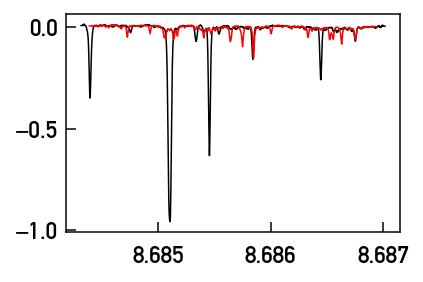

In [6]:
plt.plot(model_xs_star, model_ys_star, color='k')
plt.plot(model_xs_t, model_ys_t, color='red')
#plt.plot(data_xs, data[0,:], color='blue')

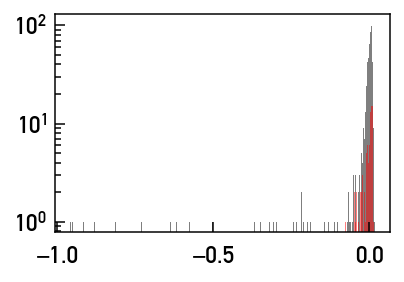

In [19]:
plt.hist(model_ys_star, color='k', alpha=0.5, bins=1000)
plt.hist(model_ys_t, color='red', alpha=0.5, bins=1000)
plt.yscale('log', nonposy='clip')
#plt.ylim((0,100))

In [20]:
stepsize = 0.001
for n in range(75):
    tmp = np.copy(x0_star)
    s = state(tmp[n], data_xs, model_xs_star)
    ddotP1 = dotdPdv(s, data[n,:])
    tmp[n] += stepsize
    s = state(tmp[n], data_xs, model_xs_star)
    dotP0 = dotP(s, data[n,:])
    tmp[n] -= 2. * stepsize
    s = state(tmp[n], data_xs, model_xs_star)
    dotP2 = dotP(s, data[n,:])    
    print ddotP1[1000:1004]
    print (dotP0 - dotP2)[1000:1004]/(2 * stepsize)

[ -2.69414869e-05  -6.94456849e-06   2.71558932e-05   1.91587986e-05]
[ -2.69371981e-05  -6.94346298e-06   2.71515703e-05   1.91557487e-05]
[  1.08835211e-05  -1.58762189e-05  -3.85632344e-05   1.49649364e-05]
[  1.08846866e-05  -1.58779190e-05  -3.85673639e-05   1.49665388e-05]
[ -1.09399898e-05  -1.39728627e-05  -7.35531635e-06  -2.70795854e-06]
[ -1.09382482e-05  -1.39706383e-05  -7.35414546e-06  -2.70752746e-06]
[  1.21707276e-05  -1.82132346e-05   2.36035890e-06   1.03890811e-05]
[  1.21720309e-05  -1.82151849e-05   2.36061165e-06   1.03901935e-05]
[  4.69326451e-06  -7.87548860e-07  -5.49822535e-06  -5.91914654e-06]
[  4.69251741e-06  -7.87423494e-07  -5.49735011e-06  -5.91820430e-06]
[ -1.11401625e-05  -2.86261252e-05  -4.50569516e-06   2.34632785e-05]
[ -1.11383891e-05  -2.86215683e-05  -4.50497792e-06   2.34595435e-05]
[ -6.86534588e-06  -1.55065481e-05  -2.10916303e-05  -2.21527018e-05]
[ -6.86608104e-06  -1.55082086e-05  -2.10938889e-05  -2.21550740e-05]
[  1.97399748e-06  -

In [21]:
stepsize = 0.01
rv_steps = np.arange(0, 10, stepsize)
M = len(data[0,:])
Pdots = np.zeros((len(rv_steps), M))
dPdots = np.zeros((len(rv_steps), M))
for i in xrange(len(rv_steps)):
    drv = rv_steps[i]
    s = state(drv, data_xs, model_xs_star)
    Pdots[i,:] = Pdot(s, model_ys_star)
    dPdots[i,:] = dPdotdv(s, model_ys_star)
    
print (Pdots[-1] - Pdots[0])[1000:1004]
print (np.sum(dPdots*stepsize, axis=0))[1000:1004]

[  1.57089485e-05  -2.40025100e-05   3.77128655e-05   1.44735039e-05]
[  1.57246733e-05  -2.40265368e-05   3.77506165e-05   1.44879921e-05]


In [22]:
def rv_lnprior(rvs):
    return -0.5 * np.mean(rvs)**2/1.**2

def drv_lnprior_dv(rvs):
    return np.zeros_like(rvs) - np.mean(rvs)/1.**2/len(rvs)

def lnlike_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_star)
    except:
        N = 1  
    lnlike = 0.
    dlnlike_dv = np.zeros(N)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dpd_dv = dPdotdv(state_star, model_ys_star)
        dlnlike_dv[n] = np.sum((data[n,:] - pd) * ivars[n,:] * dpd_dv)
    lnpost = lnlike + rv_lnprior(rvs_star)
    dlnpost_dv = dlnlike_dv + drv_lnprior_dv(rvs_star)
    return -1 * lnpost, -1 * dlnpost_dv

def lnlike_t(rvs_t, rvs_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_t)
    except:
        N = 1  
    lnlike = 0.
    dlnlike_dv = np.zeros(N)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dpd_dv = dPdotdv(state_t, model_ys_t)
        dlnlike_dv[n] = np.sum((data[n,:] - pd) * ivars[n,:] * dpd_dv)
    lnpost = lnlike + rv_lnprior(rvs_t)
    dlnpost_dv = dlnlike_dv + drv_lnprior_dv(rvs_t)
    return -1 * lnpost, -1 * dlnpost_dv



In [23]:
def model_ys_lnprior(w):
    return -0.5 * np.sum(w**2)/100.**2


def dmodel_ys_lnprior_dw(w):
    return -1.*w / 100.**2


def dlnlike_star_dw_star(model_ys_star, rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_star)
    except:
        N = 1  
    lnlike = 0.
    Mp = len(model_xs_star)
    dlnlike_dw = np.zeros(Mp)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        dp_star = dotP(state_star, (data[n,:] - pd)*ivars[n,:]) 
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dlnlike_dw += dp_star
    lnprior = model_ys_lnprior(model_ys_star)
    dlnprior = dmodel_ys_lnprior_dw(model_ys_star)
    return -lnlike - lnprior, -dlnlike_dw - dlnprior

def dlnlike_t_dw_t(model_ys_t, rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t):
    try:
        N = len(rvs_t)
    except:
        N = 1  
    lnlike = 0.
    Mp = len(model_xs_t)
    dlnlike_dw = np.zeros(Mp)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        dp_t = dotP(state_t, (data[n,:] - pd)*ivars[n,:]) 
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dlnlike_dw += dp_t
    lnprior = model_ys_lnprior(model_ys_t)
    dlnprior = dmodel_ys_lnprior_dw(model_ys_t)
    return -lnlike - lnprior, -dlnlike_dw - dlnprior

In [24]:
print dlnlike_star_dw_star(model_ys_star, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)

stepsize = 0.001
lnlike1, dlnlike_dv1 = dlnlike_star_dw_star(model_ys_star, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
for n in range(75):
    tmp = np.copy(model_ys_star)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = dlnlike_star_dw_star(tmp, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = dlnlike_star_dw_star(tmp, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)
    


(443867.67954574793, array([  9.50767486e-07,   9.50767486e-07,   9.50767486e-07, ...,
         6.34706276e-07,   6.34706276e-07,   6.34706276e-07]))
9.50767486473e-07
9.60426405072e-07
9.50767486473e-07
9.60426405072e-07
9.50767486473e-07
9.60426405072e-07
9.50767486473e-07
9.60426405072e-07
9.50767486473e-07
9.60426405072e-07
9.50767486473e-07
9.60426405072e-07
9.50767486473e-07
9.60426405072e-07
9.50767486473e-07
9.60426405072e-07
9.50767486473e-07
9.60426405072e-07
9.50767486473e-07
9.60426405072e-07
1223.59356171
1223.59356171
1998.69177424
1998.69177424
2635.63451317
2635.63451316
2205.27875769
2205.27875764
2095.19516647
2095.19516645
1946.15191326
1946.15191329
2236.67956905
2236.679569
3356.07939607
3356.07939609
4339.5678441
4339.56784406
3928.3188656
3928.3188656
3754.36230137
3754.36230141
3834.36230047
3834.36230055
4306.59634869
4306.59634867
4071.24057232
4071.24057235
4276.08536278
4276.08536277
5043.64615078
5043.64615079
4724.93108553
4724.93108551
4522.60381072
4522.

In [25]:
print dlnlike_t_dw_t(model_ys_t, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)

stepsize = 0.001
lnlike1, dlnlike_dv1 = dlnlike_t_dw_t(model_ys_t, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
for n in range(75):
    tmp = np.copy(model_ys_t)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = dlnlike_t_dw_t(tmp, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = dlnlike_t_dw_t(tmp, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)

(443867.67859593226, array([  7.83655022e-07,   7.83655022e-07,   7.83655022e-07, ...,
         2.38896489e-07,   2.38896489e-07,   2.38896489e-07]))
7.83655022199e-07
7.85803422332e-07
7.83655022199e-07
7.85803422332e-07
7.83655022199e-07
7.85803422332e-07
7.83655022199e-07
7.85803422332e-07
7.83655022199e-07
7.85803422332e-07
7.83655022199e-07
7.85803422332e-07
7.83655022199e-07
7.85803422332e-07
7.83655022199e-07
7.85803422332e-07
7.83655022199e-07
7.85803422332e-07
7.83655022199e-07
7.85803422332e-07
16515.474385
16515.4743849
17126.244434
17126.244434
17937.7633678
17937.7633678
15809.4214444
15809.4214444
15504.5267249
15504.5267249
15873.3700128
15873.3700128
17092.8434363
17092.8434363
19766.0081874
19766.0081873
19708.6072279
19708.6072279
16825.9354598
16825.9354597
16954.5417969
16954.5417968
17645.9807546
17645.9807545
17834.7031069
17834.7031069
14514.6971902
14514.6971902
16652.5931886
16652.5931886
17201.8783134
17201.8783134
15136.3476783
15136.3476783
12545.7949184
125

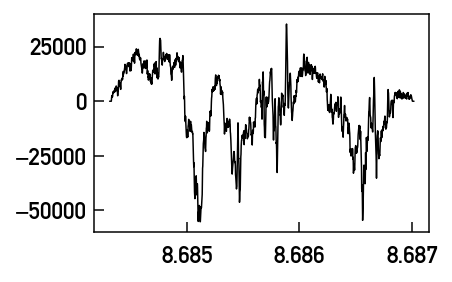

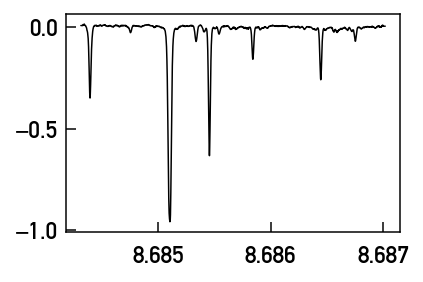

In [26]:
dw = dlnlike_star_dw_star(model_ys_star, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)[1]

plt.plot(model_xs_star, dw, 'k')
plt.show()
plt.plot(model_xs_star, model_ys_star, 'k')

In [27]:
w = np.copy(model_ys_star + np.random.normal(0, 0.01, len(model_ys_star)))
for i in range(50):
    lnlike, dlnlike_dw = dlnlike_star_dw_star(w, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    w -= 5e-7 * dlnlike_dw     


570942.838881
366115.363987
353545.678639
351335.272246
350662.484882
350409.027794
350299.525654
350246.005071
350216.746721
350199.180521
350187.840125
350180.114364
350174.638281
350170.638885
350167.648487
350165.369031
350163.602826
350162.214641
350161.109674
350160.22012
350159.496641
350158.902791
350158.411276
350158.001396
350157.657269
350157.366572
350157.119646
350156.908843
350156.728054
350156.572359
350156.437759
350156.320983
350156.219338
350156.130588
350156.05287
350155.984625
350155.924535
350155.871489
350155.82454
350155.782884
350155.745832
350155.71279
350155.683251
350155.656777
350155.632986
350155.611551
350155.592185
350155.574642
350155.558703
350155.544181


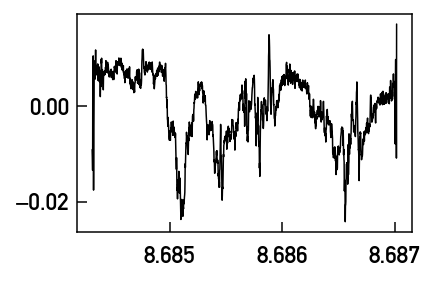

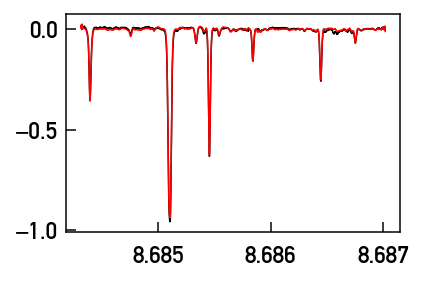

In [28]:
plt.plot(model_xs_star, model_ys_star-w, 'k')
plt.show()

plt.plot(model_xs_star, model_ys_star, 'k')
plt.plot(model_xs_star, w, 'r')

In [29]:
def improve_telluric_model(model_ys_t, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t):
    w = np.copy(model_ys_t)
    for i in range(50):
        lnlike, dlnlike_dw = dlnlike_t_dw_t(w, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
        w -= 5e-7 * dlnlike_dw    
    return w

def improve_star_model(model_ys_star, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t):
    w = np.copy(model_ys_star + np.random.normal(0, 0.01, len(model_ys_star)))
    for i in range(50):
        lnlike, dlnlike_dw = dlnlike_star_dw_star(w, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
        w -= 5e-7 * dlnlike_dw 
    return w

In [30]:
plt.plot(model_xs_t, model_ys_t-w, 'k')
plt.show()

plt.plot(model_xs_t, model_ys_t, 'k')
plt.plot(model_xs_t, w, 'r')

ValueError: operands could not be broadcast together with shapes (1540,) (1625,) 

In [ ]:
print lnlike_star(x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
print lnlike_star(true_rvs, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)

In [ ]:
test_rvs = np.linspace(-1.e3+x0_star[0], 1.e3+x0_star[0], 100)
chisq = np.zeros_like(test_rvs)
for i,v in enumerate(test_rvs):
    tmp = np.copy(x0_star)
    tmp[0] = v
    lnlike0, dlnlike_dv0 = lnlike_star(tmp, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    chisq[i] = lnlike0
    
plt.plot(test_rvs, chisq)
plt.axvline(x0_star[0])

In [ ]:
stepsize = 0.001
lnlike1, dlnlike_dv1 = lnlike_star(x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
for n in range(75):
    tmp = np.copy(x0_star)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = lnlike_star(tmp, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = lnlike_star(tmp, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)

In [ ]:
stepsize = 0.001
lnlike1, dlnlike_dv1 = lnlike_t(x0_t, x0_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
for n in range(75):
    tmp = np.copy(x0_t)
    tmp[n] += stepsize
    lnlike0, dlnlike_dv0 = lnlike_t(tmp, x0_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    tmp[n] -= 2. * stepsize
    lnlike2, dlnlike_dv2 = lnlike_t(tmp, x0_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t)
    print dlnlike_dv1[n]
    print (lnlike0 - lnlike2)/(2 * stepsize)

In [ ]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
print np.std(soln_star + true_rvs)

In [ ]:
plt.scatter(np.arange(N), x0_star)
plt.scatter(np.arange(N), soln_star)
plt.scatter(np.arange(N), -true_rvs)
plt.show()

In [ ]:
print soln_star - x0_star

In [ ]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

x0_star = soln_star
x0_t = soln_t
print np.std(x0_star + true_rvs)
print np.std(x0_t)

In [ ]:
plt.scatter(np.arange(N), soln_star + true_rvs)

In [ ]:
data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)

In [ ]:
data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

In [ ]:
plt.plot(data_xs, data[0,:], color='black')
plt.plot(model_xs_star, model_ys_star, color='red')
plt.plot(model_xs_t, model_ys_t, color='green')

In [ ]:
soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']


print np.std(soln_star + true_rvs)
print np.std(soln_t)

In [ ]:
plt.scatter(np.arange(N), soln_star + true_rvs)

In [ ]:
for n in range(5):
    soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    
    model_ys_t = improve_telluric_model(model_ys_t, soln_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    model_ys_star = improve_star_model(model_ys_star, soln_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)

    soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    
    model_ys_t = improve_telluric_model(model_ys_t, soln_star, soln_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    model_ys_star = improve_star_model(model_ys_star, soln_star, soln_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    
    x0_star = soln_star
    x0_t = soln_t

    print "iter {0}: star std = {1:.2f}, telluric std = {2:.2f}".format(n, np.std(soln_star + true_rvs), np.std(soln_t))
    plt.scatter(np.arange(N), soln_star + true_rvs, color='k')
    plt.scatter(np.arange(N), soln_t, color='red')
    plt.show()


In [ ]:
plt.scatter(bervs, soln_star+true_rvs)

In [ ]:
plt.plot(data_xs, data[0,:], color='k')
plt.plot(data_xs, data_star[0,:] + data_t[0,:], color='red')

In [ ]:
plt.plot(data_xs, data[0,:] - data_star[0,:] - data_t[0,:])

In [ ]:
plt.hist(data[0,:] - data_star[0,:] - data_t[0,:])